# Recurrent Neural Network

## Part 1 - Data Preprocessing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the libraries

### Importing the training set

In [ ]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values # 데이터를 넘파이 배열로 만듬. 구글 주가의 시작가만 가져옴.

### Feature Scaling

In [ ]:
# 여기서는 표준화(Standardisation)가 아닌 정규화(Normalisation)가 적합 -> (x - min(x)) / (max(x) - min(x))
# 순환 신경망을 구축할 때 마다 특히 순환신경망의 출력층에 활성화 함수로 시그모이드 함수가 있는 경우 정규화 적용 권장.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1)) # 매개변수 feature_range=(0,1) -> 디폴트 범위(0~1), copy=True 가 디폴트. 우리는 디폴트를 사용.
training_set_scaled = sc.fit_transform(training_set) # fit은 공식을 적용할 수 있도록 min, max값만 구하는 과정. transfor은 훈련 집합의 각 데이터에 대해 계산.

### Creating a data structure with 60 timesteps and 1 output

In [ ]:
# 60개의 타임스텝은 T마다 RNN은 시간 T시간 전에 60개의 주가를 봄.
# 그 주가는 T시간 60일 전부터 T시간 사이의 주가임.
# 트렌드를 보면 이 60개의 이전 타임스템 동안 수집한 것임.
# 순환 신경망이 학습하고 이해하려는 과거 정보의 60가지 타임스텝을 통해 상관관계나 트렌드 파악 가능.
# 그리고 그 이해를 바탕으로 다음 출력을 예측하려 함. 즉, 시간 T+1의 주가임.
# 60은 직접 실험해본 숫자. 다른 타임 스텝도 가능. 1개의 타임스텝으로 했더니 과적합...
# 20은 몇가지의 트렌드를 포착하기에는 부족했음. 결국 60이 좋았음.
# 60개의 타임스텝은 물론 60일의 이전 주식시장과 일치. 한달에 20일의 주식시장이 있으므로 3개월에 해당.
# 우리는 매일 3개월 전을 보고 다음날의 주가를 예측.

In [ ]:
X_train = []
y_train = []
for i in range(60, 1258): # 상한선은 1258(자료 개수가 총 1258개)
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train) # 넘파이 배열로 변환
# 각 관찰(주식시장)에 대해 X_train에는 해당 주식시장 전에 60개의 미리 볼 수 있는 주가가 포함.
# y_train은 다음 주식시장의 주가를 포함.
# 이것이 바로 순환신경망 -> 시간 T+1에 해당하는 값을 예측하기 위해 이전 60개의 타임스텝에서 무슨 일이 일어났는지 기억.

### Reshaping

In [ ]:
# 위에서 만든 데이터 구조에 더 많은 차원을 추가하는 데이터 재구성에 대한 것.
# 추가할 차원은 단위 즉, 원하는 것을 예측하기 위해 사용할 수 있는 예측 변수의 수(T+1시점의 구글 주가)
# 지금 우리는 시작가라는 한가지 지표만 가지고 있음. 그리고 60개의 이전 구글 시작 주가를 가지고 다음 주가를 예측. 이게 유일한 지표.
# 하지만 데이터 구조에 새로운 차원을 추가할 것임.
# 구글 주가의 상승과 하락 추세를 더 잘 예측하는데 도움이 될 수 있다고 생각하면 몇 가지 지표를 더 추가할 수 있음.
# 이 구현에서는 하지 않을 것임. 그냥 시작가만 사용.
# 하지만 새로운 데이터 구조 및 새로운 차원을 원한다면 몇가지 지표를 추가 가능.

In [ ]:
# 새로운 차원 추가. 넘파이 배열에 차원 추가 시 항상 reshape() 메서드를 사용해야 함.
# X_train은 신경망의 입력을 포함하고 있으므로  X_train에만 적용하면 됨.
# 더 많은 지표 사용 가능 + RNN의 입력 형식에 호환될 수 있도록 하기 위함.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # 지금 X_train은 2차원. 차원 추가시 3차원.
# 괄호안에 포함해야 할 차원의 순서를 정확히 알려면 케라스 문서로 가야 함.(RNN의 입력형식을 보기 위함.)
# 총 3차원
# 1. 배치 크기 -> 총 관측치 수. -> 첫번째 차원
# 2. 타임스텝 수 -> 60 -> 두번째 차원
# 3. 예측변수에 해당하는 차원(가지고 있는 지표의 수.. 우리는 1). 지표가 여러개면 그 개수만큼 입력. -> 세번째 차원
# 이건 구글의 주가 추이를 예측하는데 도움이 될 수 있는 새로운 금융 지표가 될 수 있음.
# 예를 들어 이건 마감 구글 주가일 수도 있고, 다른 회사의 다른 주가일 수도 있음.

## Part 2 - Building and Training the RNN

In [ ]:
# 탄탄한 아키텍처를 위해 simple LSTM(장단기 메모리층)은 만들지 않음.
# 과적합 방지를 위해 드롭아웃 정규화를 통해 스택형 LSTM을 만들 예정.

### Importing the Keras libraries and packages

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

### Initialising the RNN

In [ ]:
regressor = Sequential() # 연속된 출력(T+1)을 예측하기 때문에 regressor이라고 변수를 설정. 우리는 회귀를 하고 있음.

### Adding the first LSTM layer and some Dropout regularisation

In [ ]:
# 드롭아웃 정규화를 추가하는 이유 -> 과적합 방지.
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [ ]:
# LSTM layer 추가. 매개변수는 총 3개

# 1. LSTM 층에서 가질 셀 또는 단위 수(기억창치 개수). 그냥 단순하게 하기 위해 뉴런이라고 부르겠음.
# 많은 층을 쌓을지라도 우리의 모델이 매우 높은 차원성을 갖기를 원함.
# 따라서 차원성을 높이게 될 것임. 우리가 추가할 여러 장단기 메모리 층들 때문
# 하지만 우리는 각 장단기 메모리 층에 많은 수의 뉴런을 포함시켜 차원을 더 늘릴 수 있음.
# 주가의 동향을 파악하는 건 매우 복잡하기 때문에 높은 차원을 가질 필요가 있고
# 따라서 여러 장단기 메모리 층 각각에 많은 수의 뉴런을 가질 필요가 있음.
# 따라서 첫 번째 장단기 메모리 층에 선택할 뉴런의 수는 50.
# 다음 층에도 뉴런 수가 50이므로 고차원적인 모델을 얻을 수 있음.
# 문제의 복잡성을 처리 가능. 모델 차원 증가 시 동시에 복잡성도 증가. 고로 문제의 복잡성에 더 잘 대응 및 더 나은 결과 얻을 수 있음.
# 만약 각각의 장단기 메모리 층에서 너무 적은 수의 뉴런을 선택했다면(예를 들면 3에서 5개의 뉴런)
# 이건 너무 적어서 상승과 하락 추세를 잘 포착할 수 없을 것임.

# 2. return_sequences(반환 순서)-> True와 동일하게 설정해야 함. 스택형 LSTM을 구축하고 있기 때문에 여러개의 LSTM층을 가질 수 있음.
# 여러 개의 장단기 메모리 층을 가질 수 있음. 그리고 지금 만들고 있는 장단기 메모리 층 뒤에 다른 층을 추가하면
# 반환 시퀀스 인수를 참으로 설정해야 함.
# 장단기 메모리 층을 모두 처리한 후에는 다른 층을 추가하지 않고 False으로 설정.
# 이것은 반환 시퀀스 매개 변수의 기본값이기 때문에 이 작업을 수행할 필요가 없음.

# 3. input_shape -> 데이터 전처리 부분의 마지막 단계에서 만든 X_train을 포함하는 입력의 형태.(3차원의 입력형태)
# 하지만 장단기 메모리 클래스의 세 번째 인수에서 3차원을 포함할 필요가 없음.
# 타임스텝과 지표에 해당하는 마지막 두 개만 있음. 관측치에 해당하는 첫 번째 것이 자동으로 고려되기 때문.
# 따라서 타임스텝에 상응하는 X_train.shape[1]을 명시. 그리고 1은예측 변수, 지표에 상응.

In [ ]:
# 드롭아웃 정규화
# 정규화를 수행하려면 계층에서 드롭하고 싶은 뉴런의 비율인 드롭아웃 비율을 지정해야 함.
# 그리고 추천하는 숫자는 뉴런의 20%를 떨어뜨리는 것이고 이건 꽤 적절함.
# 그리고 20%가 바로 여기에 입력해야 함.
# 그래서 20%의 드롭아웃 즉, LSTM 층의 20%의 뉴런이 훈련 중에 무시됨.
# 훈련의 각 반복에서 발생하는 forward propagation과 back propagation를 말함.
# 따라서 50개의 20%는 10개의 뉴런이기에 10개의 뉴런이 무시되고 훈련의 각 반복 동안 버려지게 됨.

In [ ]:
# 이제 총 4개의 LSTM층을 추가할 때까지 LSTM층을 추가할 것임.
# 그래서 큰 스택형 LSTM을 만들 수 있음.

### Adding a second LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [ ]:
regressor.add(Dense(units = 1)) # 완전연결층으로 추가(ANN, CNN과 같음)
# T+1시점에서의 주가에 상응하는 실제 가치를 예측하고 있으므로 출력으로 단 하나의 차원만 가짐.

### Compiling the RNN

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# 옵티마이저 RMSProp -> 일종의 진보된 확률적 경사 하강 최적화 도구
# 추천하는 방법이며 좋은 선택이긴 하지만 우리는 사용안함. 개인적으로 시도해보기.
# 우리는 adam 옵티마이저를 사용. 항상 안전한 선택지임. 매우 강력. 관련 가중치 업데이트를 수행하므로 항상 좋은 선택지임.
# RNN과 가장 관련된 옵티마이저는 RMSProp 과 adam.
# 손실함수는 분류가 아니므로 교차 엔트로피는 아님. 회귀를 다루고 있으므로 평균제곱오차를 사용.

### Fitting the RNN to the Training set

In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
# 실험 결과 epochs = 100 이 적합.

Epoch 1/100
38/38 [==============================] - 21s 124ms/step - loss: 0.0556
Epoch 2/100
38/38 [==============================] - 4s 118ms/step - loss: 0.0068
Epoch 3/100
38/38 [==============================] - 6s 164ms/step - loss: 0.0050
Epoch 4/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0050
Epoch 5/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0049
Epoch 6/100
38/38 [==============================] - 7s 189ms/step - loss: 0.0051
Epoch 7/100
38/38 [==============================] - 6s 143ms/step - loss: 0.0045
Epoch 8/100
38/38 [==============================] - 6s 163ms/step - loss: 0.0045
Epoch 9/100
38/38 [==============================] - 4s 116ms/step - loss: 0.0051
Epoch 10/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0041
Epoch 11/100
38/38 [==============================] - 6s 160ms/step - loss: 0.0040
Epoch 12/100
38/38 [==============================] - 5s 120ms/step - loss: 0.0045
Epoch 13/100

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017.01


In [ ]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values # 데이터를 넘파이 배열로 만듬. 구글 주가의 시작가만 가져옴.

### Getting the predicted stock price of 2017.01

In [ ]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) # 2012~2016까지의 시작가와 2017.01의 시작가를 합침.
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# 하한선: 1월3일 주가 - 60일 ... len(dataset_total) - len(dataset_test) -> 1월 3일 데이터 인덱스
# 상한선: 전체 데이터 세트의 마지막 인덱스

inputs = inputs.reshape(-1, 1) # 위에서 iloc를 사용X -> 원하는 넘파이배열(2차원)이 만들어지지 않아서 이렇게 작성.

inputs = sc.transform(inputs) # 스케일링

X_test = []
for i in range(60, 80): # 테스트 세트는 20일의 주식장만 포함 상한선: 60+20
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test) # 넘파이 배열로 변환

# reshape()로 입력에 대한 3차원 구조를 만듬(입력에 대한 올바른 형식 때문)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)

# 역변환
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 4s 4s/step


In [ ]:
print(predicted_stock_price)

[[775.81665]
 [773.0641 ]
 [772.8609 ]
 [774.11   ]
 [777.1657 ]
 [782.3741 ]
 [787.312  ]
 [789.5333 ]
 [789.877  ]
 [789.69434]
 [789.7866 ]
 [790.12085]
 [790.48395]
 [791.1695 ]
 [791.9923 ]
 [795.69073]
 [801.668  ]
 [808.39795]
 [812.4074 ]
 [809.36615]]


### Visualising the results

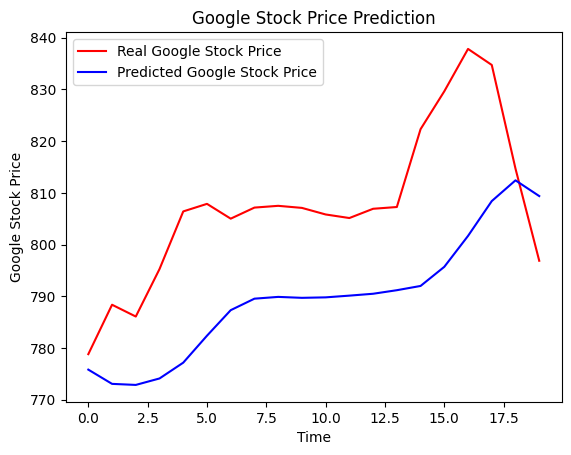

In [ ]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()